# BOMR 2021

### Dependency installation

In [1]:
!pip install --quiet opencv-python tqdm matplotlib numpy ipywidgets imutils
!jupyter nbextension enable --py widgetsnbextension
!pip install --quiet --upgrade tdmclient

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


### Imports


In [1]:
import sys as _sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from time import sleep, time
import ipywidgets as widgets
_sys.path.append("./src")
import ipywidgets
from global_navigation import Path_planner
from vision import Vision
from IPython.display import clear_output
from visualizer import *
from movement import move
from Kalman_filter import Kalman_filter
import tdmclient.notebook
from local_navigation import *
from time import sleep
from PIL import ImageColor

%matplotlib inline


In [2]:
vision = Vision()
path_planner = Path_planner()


In [21]:
def pltshow(img):
    clear_output(wait = True)
    plt.imshow(img)
    plt.show()
    
robot_cp = widgets.ColorPicker(
    concise=False,
    description='Robot',
    value='red',
    disabled=False
)
obstacles_cp = widgets.ColorPicker(
    concise=False,
    description='Obstacles',
    value='blue',
    disabled=False
)
goal_cp = widgets.ColorPicker(
    concise=False,
    description='Goal',
    value='green',
    disabled=False
)

from ipywidgets import Layout, Button, Box

items_layout = Layout( width='auto')     # override the default width of the button to 'auto' to let the button grow

box_layout = Layout(display='flex',
                    flex_flow='column',
                    align_items='stretch',
                    width='100%')

items = [robot_cp, goal_cp, obstacles_cp]
box_cp = Box(children=items, layout=box_layout)

In [4]:
from tdmclient import ClientAsync, aw
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()
await node.wait_for_variables()

## Connect to camera and calibrate exposure

In [5]:
vision.connect_camera(0)

## Calibration



In [6]:
for i in range(10):
    sleep(0.1)
    vision.update_frame()

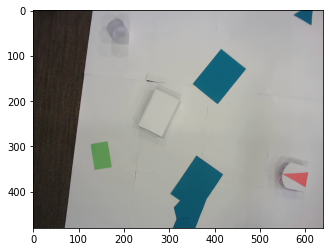

In [7]:
vision.vc.set(15,-5) #exposure
vision.vc.set(11,100) #contrast

vision.update_frame()
im = plt.imshow(vision.actual_frame)

#### set colors of elements

In [22]:
box_cp

Box(children=(ColorPicker(value='red', description='Robot'), ColorPicker(value='green', description='Goal'), C…

In [8]:
robot_color = np.array(ImageColor.getcolor(robot_cp.value, "RGB")))
goal_color = np.array(ImageColor.getcolor(goal_cp.value, "RGB"))
obstacles_color = np.array(ImageColor.getcolor(obstacles.value, "RGB"))

vision.set_colors(obstacles_color, robot_color, goal_color)

In [9]:
goalthresh = 20
robotthresh = 20
obstaclesthresh = 40
vision.set_tresh(goalthresh, robotthresh, obstaclesthresh)

### Test vision

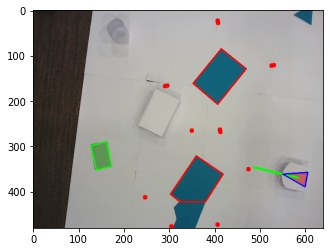

In [10]:
vision.update()
pltshow(vision.create_full_mask())

## set mm to px

In [11]:
vision.set_mm2px()

mm/px ratio :  0.49074612380947696



### Plan path

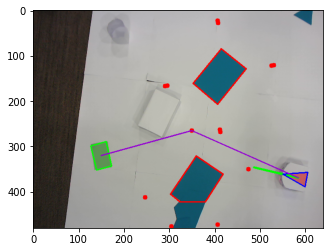

In [12]:
path_planner.make_path(vision)
pltshow(get_visualization(vision, path_planner))

# Run

In [15]:
set_speed(0,0, node)


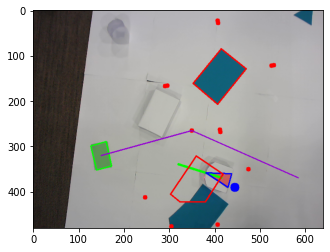

[445.68010152737304, 390.66696317213564, -213.619244332162] [350 265]
157.94577379972947 -127.80373607625852 127.28485908307265


KeyboardInterrupt: 

In [14]:
from IPython.display import clear_output
vision.update_frame()
vision.update_robot()
kalman = Kalman_filter(vision)
plt.figure()
vision.update_robot()
pltshow(get_visualization(vision, path_planner))
next_point_id = 1
next_point = path_planner.path[next_point_id]
# send next_point
# init kalmann
min_dist = 30
t0 = time()
prox_and_memory = np.zeros(7)
k_ann = 1500
offset_ann = 150
while 1:
    vision.update_frame()
    vision.update_robot()
    robot_speed = get_speed(node)
    kalman.update_kalman(vision, robot_speed, time() - t0)
    t0 = time()
    pltshow(get_visualization_kalman(vision, path_planner,kalman))

    if vision.robot_detected():
        pos = [kalman.rho_est[0,0], kalman.rho_est[1,1], kalman.rho_est[2,2]]
        speed_robot,dop = move(vision, pos, next_point, 0.3, 300,250, 120, (np.linalg.norm(vision.robot.center - path_planner.path[next_point_id-1]) < min_dist))
        prox_and_memory[0:5] = np.array([x for x in node['prox.horizontal'][0:5]])
        w_l = np.array([40,20,-25,-20,-40, 12, 0])
        w_r = np.array([-40,-20,-20,20,40, 0, 12])
        v_l = w_l.dot(prox_and_memory)
        v_r = w_r.dot(prox_and_memory)
        
        if (prox_and_memory[:5] > 200).any():
            speed_l =  int(v_l/k_ann) + offset_ann
            speed_r =  int(v_r/k_ann) + offset_ann
        else:  
            speed_l = speed_robot[0] + int(w_l[5:].dot(prox_and_memory[5:])/200)
            speed_r = speed_robot[1] + int(w_r[5:].dot(prox_and_memory[5:])/200)
        prox_and_memory[5] = speed_l//10  
        prox_and_memory[6] = speed_r//10
        
        set_speed(speed_l, speed_r, node)
#         set_speed(0,0)
#         print(speed_robot, dpos, next_point_id)
        # CHECKPOINT 
        
        
        if np.linalg.norm(vision.robot.center - next_point) < min_dist:
            if next_point_id == len(path_planner.path) - 1:
                print("arrived at destination")
                set_speed(0,0,node)
                break
            else:
                print("arrived at checkpoint")
                next_point_id += 1
                next_point = path_planner.path[next_point_id]
                

In [17]:
 vision.disconnect_camera()